In [2]:
import torch 
from torch import nn 

import matplotlib.pyplot as plt

In [83]:
A = torch.randn(2,2)
A = A@A.T

x =torch.randn(10,2)



In [91]:
torch.einsum("bi, ij, bj-> b", x, A, x)

tensor([ 0.9970,  0.6651,  1.2360,  0.5444,  2.2130,  6.2871,  0.1921, 14.7207,
         0.0221,  4.9205])

In [93]:
res = 0
for i in range(2):
    for j in range(2):
        res += A[i,j]*x[:,i]*x[:,j]
res

tensor([ 0.9970,  0.6651,  1.2360,  0.5444,  2.2130,  6.2871,  0.1921, 14.7207,
         0.0221,  4.9205])

In [62]:
torch.einsum("ij, ij -> i", x,(A@x.T).squeeze().T)

tensor([-1.4201, -7.7996,  3.7540, -0.9085,  0.1976,  0.1958, -0.1781,  0.5214,
         0.9332,  1.2803])

In [2]:
torch.manual_seed(0)

In [67]:
def generate_dataset(N=1000, d=1):
    X = torch.randn((N, d))*10
    Y = torch.sin(X)*X - 0.1*X**2 + 2*X +  torch.randn_like(X)*X*0.5
    return X, Y

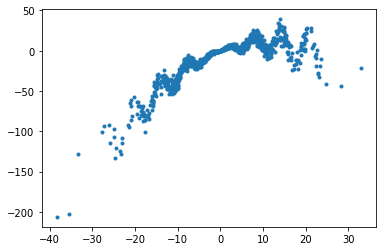

In [68]:
X,Y = generate_dataset()
plt.plot(X,Y, ".")

In [69]:
def batch_jacobian(func, x, create_graph=True):
  # x in shape (Batch, Length)
  def _func_sum(x):
    return func(x).sum(dim=0)
  return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

def fisher_information(mean, scale):
    var = scale**2
    return torch.diag_embed(torch.hstack([1/var, 2/var]))

def gaussian_loss(y, mean, scale):
    p = torch.distributions.Normal(mean, scale)
    return p.log_prob(y).sum()

In [70]:
class GaussianNet(nn.Module):
    def __init__(self, d=1, hidden_dim=100):
        super().__init__()
        self.pre_net = nn.Sequential(nn.Linear(d, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),nn.Linear(hidden_dim, hidden_dim), nn.ReLU())
        self.mean_net = nn.Linear(hidden_dim, d)
        self.scale_net = nn.Sequential(nn.Linear(hidden_dim, d), nn.ELU())

    def forward(self, x):
        h = self.pre_net(x)
        return self.mean_net(h), self.scale_net(h)+1

In [71]:
net = GaussianNet()

In [72]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
for i in range(10000):
    optim.zero_grad()
    mean, scale = net(X)
    loss = -gaussian_loss(Y, mean, scale)
    if (i % 1000) == 0:
        print(loss.detach())
    loss.backward()
    optim.step()

tensor(157097.6875)
tensor(2783.9775)
tensor(2635.3086)
tensor(2611.9829)
tensor(2602.2795)
tensor(2594.0972)
tensor(2581.9990)
tensor(2559.7822)
tensor(2560.5022)
tensor(2518.5051)


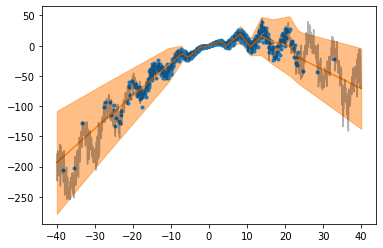

In [75]:
x = torch.linspace(-40,40, 1000)
plt.plot(X,Y, ".")
m_pred, s_pred = net(x.reshape(-1,1))
plt.plot(x, m_pred.detach().flatten())
plt.fill_between(x, m_pred.detach().flatten()-2.96*s_pred.flatten().detach(), m_pred.detach().flatten()+2.96*s_pred.flatten().detach(), alpha=0.5, color="C1")
plt.plot(x, torch.sin(x)*x - 0.1*x**2 + 2*x +  torch.randn_like(x)*x*0.5, color="black", alpha=0.3)

In [76]:
net = GaussianNet()

In [77]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
lam = 0.1
for i in range(10000):
    optim.zero_grad()
    mean, scale = net(X)
    Js = batch_jacobian(lambda x: torch.hstack(net(x)), X)
    loss = -gaussian_loss(Y, mean, scale) + lam*torch.diagonal(fisher_information(mean, scale).squeeze()@(Js@torch.transpose(Js, -2,-1)).squeeze(), dim1=-2, dim2=-1).sum()
    if (i % 1000) == 0:
        print(loss.detach())
    loss.backward()
    optim.step()

tensor(480129.4688)
tensor(2926.5793)
tensor(2900.5254)
tensor(2896.2056)
tensor(2887.5464)
tensor(2888.7830)
tensor(2875.4546)
tensor(2887.1360)
tensor(2874.1072)
tensor(2866.6746)


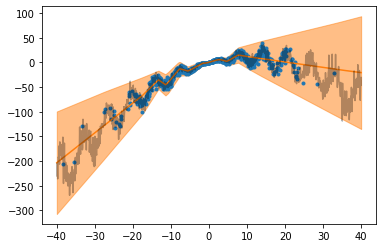

In [79]:
x = torch.linspace(-40,40, 1000)
plt.plot(X,Y, ".")
m_pred, s_pred = net(x.reshape(-1,1))
plt.plot(x, m_pred.detach().flatten())
plt.fill_between(x, m_pred.detach().flatten()-2.96*s_pred.flatten().detach(), m_pred.detach().flatten()+2.96*s_pred.flatten().detach(), alpha=0.5, color="C1")
plt.plot(x, torch.sin(x)*x - 0.1*x**2 + 2*x +  torch.randn_like(x)*x*0.5, color="black", alpha=0.3)